In [136]:
import sys, getopt, os.path
import matplotlib.pyplot as plt
import numpy as np

import math,h5py, pandas
from scipy import integrate
from scipy.fftpack import fft, hilbert
from scipy.signal import butter, lfilter
from geopy.distance import great_circle
import matplotlib.ticker as ticker
import yaml
import netCDF4 as nc

import pandas as pd
import time
import copy

In [137]:
flag_project = 1

if flag_project == 0:
    file_project = 'a-project.yml'
elif flag_project == 1:
    file_project = 'a-project_repar.yml'
elif flag_project == 2:
    file_project = 'a-project_voro.yml'
    
with open(file_project, 'r', encoding='utf-8') as f:
    proj = yaml.load(f.read(), Loader=yaml.FullLoader)
name_project = proj['name']
name_project = 'project_repartition_v4.0/output_repar_v9.2_01-01/'

In [138]:
with open('0_config.yml', 'r', encoding='utf-8') as f:
    dir_config = yaml.load(f.read(), Loader=yaml.FullLoader)
dir_project_workspace = dir_config['dir_project_workspace']
dir_CC_workspace = dir_config['dir_CC_workspace']
print('dir_CC_workspace: ', dir_CC_workspace)
print('dir_project_workspace: ', dir_project_workspace)
dir_project = os.path.join(dir_project_workspace, name_project)
print('dir_project: ', dir_project)

dir_CC_workspace:  ./
dir_project_workspace:  ./
dir_project:  ./project_repartition_v4.0/output_repar_v9.2_01-01/


In [139]:
filename = dir_project+'Basic_info.yml'
with open(filename, 'r', encoding='utf-8') as f:
    info_basic = yaml.load(f.read(), Loader=yaml.FullLoader)
filename_bi = dir_project+'Basic_info.npy'
info_basic_bi = np.load(filename_bi, allow_pickle='TRUE').item()      # setting dictionary

In [140]:
dir_image = dir_project + info_basic['rdir_image']+'model_validate/'
dir_partition = dir_project + info_basic['rdir_partition']
dir_disp = dir_project + info_basic['rdir_disp_model']
if not os.path.exists(dir_image):
    os.makedirs(dir_image)
#dir_CC = os.getcwd()+'/'+dir_CC_workspace[1:] + info_basic['rdir_CC']
dir_CC = dir_CC_workspace + 'CC/CC_150_prewhiten/'
#dir_CC = dir_CC_workspace + 'CC/CC_40_prewhiten/'
key_subworks = info_basic['key_subworks']
M = len(key_subworks)
dir_file = os.getcwd()+'/ModelValidCode/ModelValidCode/parameter_prepare/'

In [141]:
stalistname_all = dir_project +'stations_all_trans.txt'
stainfo = np.loadtxt(stalistname_all, dtype={'names':('Station', 'x', 'y'), 'formats':('U32', 'f4', 'f4')})
stalist_all = stainfo['Station'].tolist()
x_stations_all =  stainfo['x'].tolist()
y_stations_all =  stainfo['y'].tolist()
stalistname_all = info_basic['stalistname_all']
stainfo = pd.read_excel(stalistname_all)
elevation_stations_all = stainfo['elevation'].tolist()

In [142]:
# fault surface trace
faults = np.load(dir_project +'clark_faults_trans.npy', allow_pickle='TRUE').item()

In [143]:
file_partition = dir_project + 'partition_trans.txt'
loc_partition = np.loadtxt(file_partition, dtype={'names':('key_subworks','x', 'y'), 'formats':('U32','f4', 'f4')})
x_partition = loc_partition['x'].tolist()
y_partition = loc_partition['y'].tolist()
key_subworks = loc_partition['key_subworks'].tolist()

In [144]:
f_list = [5,10,15]
phase = {}
for f in f_list:
    phase[f] = []
for key in key_subworks:
    disp = np.loadtxt(dir_disp + 'disp_model_'+key+'.txt')
    disp = disp[disp[:,2] == 0]
    for f in f_list:
        phase[f].append(disp[disp[:,0]==f][0][1])

In [ ]:
def ricker(t,fc,t0):
 if (t<=0.0):
    v=0.0
 f0 = np.sqrt(math.pi)/2.0
 u = (t-t0)*2.0*math.pi*fc
 v=(u**2.0/4.0-0.5)*np.exp(-u**2.0/4.0)*f0
 return v

def butter_bandpass(lowcut, highcut, fs, order=2):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='bandpass')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=2):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

def getSNR(cfsf,r,f,SNRmin):
    NoiseWinLength = 5 # in seconds
    SigWinC = np.array([0.35,0.55]) #signal window for velocity, in km/s
    SigWinT = np.zeros((len(r),2))
    SNR = np.zeros(np.shape(r))
    for i in range(len(r)):
        SigWinT[i,:] = r[i]/SigWinC

    dt = 1/np.max(f)
    t = (np.linspace(-len(f)/2,len(f)/2-1,len(f))-0.5)*dt
    cfst = np.zeros(np.shape(cfsf))
    for i in range(len(cfsf)):
        cfst[i,:] = np.real(np.fft.fftshift(np.fft.ifft(cfsf[i,:])))
        cfst[i,:] = cfst[i,:] /np.max(cfst[i,:])

    id0 = int(len(t)/2)
    cfst12 = cfst[:,id0::]
    cfst21 = cfst[:,id0::-1]
    for j in range(len(r)):
        c12h= hilbert(cfst12[j,:])
        c21h= hilbert(cfst21[j,:])
        groupCF12 = np.sqrt(cfst12[j,:]**2 + c12h**2)
        groupCF21 = np.sqrt(cfst21[j,:]**2 + c21h**2)
        nnSigWinL = int(np.ceil(SigWinT[j,1]/dt))
        nnSigWinR = int(np.floor(SigWinT[j,0]/dt))
        if nnSigWinL >= nnSigWinR:
            continue
        nnNoiseWinL = nnSigWinR
        nnNoiseWinR = nnSigWinR+int(round(NoiseWinLength/dt))

        #print("nnSigWinL: ",nnSigWinL)
        #print("nnSigWinR: ",nnSigWinR)
        SigAmp12 = np.max(groupCF12[nnSigWinL:nnSigWinR])
        SigAmpAve12 = np.mean(groupCF12[nnSigWinL:nnSigWinR])
        NoiseAmpAve12 = np.mean(groupCF12[nnNoiseWinL:nnNoiseWinR])
        if NoiseAmpAve12 == 0:
            if SigAmp12 > 0:
                SNR12 = 100
            else:
                SNR12 = 0
        else:
            SNR12 = SigAmp12/NoiseAmpAve12

        SigAmp21 = np.max(groupCF21[nnSigWinL:nnSigWinR])
        SigAmpAve21 = np.mean(groupCF21[nnSigWinL:nnSigWinR])
        NoiseAmpAve21 = np.mean(groupCF21[nnNoiseWinL:nnNoiseWinR])
        if NoiseAmpAve21 == 0:
            if SigAmp21 > 0:
                SNR21 = 100
            else:
                SNR21 = 0
        else:
            SNR21 = SigAmp21/NoiseAmpAve21

        SNR[j] = np.nan_to_num(min(SNR12,SNR21))
        
    idx = []
    for k in range(len(r)):
        if SNR[k] < np.mean(SNR)*SNRmin:
            idx.append(k)

    return idx

In [22]:
# obs parameters
isline = False
LenFD = 3
putinrou = [dir_CC + 'CFs_modelvalidate/'+ 'gather_all_modelvalidate.h5']
syn_stalist = dir_file + 'stations_in.txt'
sele_stalist = dir_file + 'stations_in.txt'
srclist = dir_file + 'stations_virsrc.txt'
#=============================read observed Ccfs====================================
CC_file = []
CC_prof = []
for i in range(len(putinrou)):
  CC_prof.append(pandas.read_hdf(putinrou[i], 'cc_prof'))
  with h5py.File(putinrou[i], mode = "r") as file_rou:
      CC_file.append(np.array(file_rou[list(file_rou.keys())[0]]))
CC_array = CC_file[0]
CC_table = CC_prof[0]
f_prof = pandas.read_hdf(putinrou[0], 'freq')
freq = np.array(f_prof[:])[:,0]

### Sync configuration

In [193]:
flag_maxd = 0.08
flag_SNRmin = 0.8
f_rick_c = 10
t_rick_shift = 0.15

In [194]:
def extract_sync(isrc,dir_src,flag_maxd,flag_SNRmin,f_rick_c,t_rick_shift,bands,CC_array,CC_table,freq,srclist,sele_stalist,syn_stalist):
  
  inputpath = dir_src + 'input/'
  outputpath = dir_src + 'output/'
  fileFDconf = dir_src + 'SeisFD3D.conf'
  virsta = []
  sta_profile = pandas.read_table(srclist, header=None, sep='\\s+')
  net = list(sta_profile[0][:])
  sta = list(sta_profile[1][:])
  for i in range(len(sta)):
      virsta.append(str(sta[i]))
  srcsta = virsta[isrc-1]
  print('srouce: ', str(isrc) ,'  srcsta:\t', srcsta)
  #==============selec Ccfs based on srcstat=====================================
  sele_netsta = []
  with open(sele_stalist, 'r') as f:
      while True:
          tmp = f.readline()
          if tmp:
              sele_netsta.append(tmp.split()[0] + '-' + tmp.split()[1])
          else:
              break

  part_CC = []
  part_dis = []
  CC_sta_name = []
  cc_name = CC_table['0cc_name']
  indexes = []
  for i in range(len(cc_name)):
      cc_pairs_sta2 = cc_name[i].split('_')
      netsta1 = cc_pairs_sta2[0]
      netsta2 = cc_pairs_sta2[1]
      #print(cc_pairs_sta2)
      if srcsta in cc_pairs_sta2:
      #if (netsta1 in sele_netsta) and (netsta2 in sele_netsta) and (srcsta in cc_pairs_sta2):
        indexes.append(i)
        part_CC.append((CC_array[i,:]).copy())
        part_dis.append(CC_table.iloc[i,3]) #km
        if srcsta == netsta1:
            CC_sta_name.append(netsta2)
        else:
            CC_sta_name.append(netsta1)

  #print("CC_sta_name: ", CC_sta_name)
  part_CC = np.array(part_CC)
  part_dis = np.array(part_dis)
  dele_cc_rows = []
  for CC_num in range(part_CC.shape[0]):
    #if part_CC[CC_num,:].all() == 0:
        #print(CC_num)
        #dele_cc_rows.append(CC_num)
    if part_dis[CC_num] == 0 or part_dis[CC_num]>= flag_maxd:
        dele_cc_rows.append(CC_num)
  dele_cc_rows = list(set(dele_cc_rows))
  dele_cc_rows.sort()
  raw_rou_nonezerocc = np.delete(part_CC, dele_cc_rows, axis = 0)
  dis_vin_nonezerocc = np.delete(part_dis, dele_cc_rows, axis = 0)
  for counter, index in enumerate(dele_cc_rows):
      index = index-counter
      CC_sta_name.pop(index)

  #print("raw_rou_nonezerocc: ", raw_rou_nonezerocc.shape)
  #print("dis_vin_nonezerocc: ", dis_vin_nonezerocc.shape)
  #print("time: ", time)

  idel = getSNR(raw_rou_nonezerocc,dis_vin_nonezerocc,freq,SNRmin=flag_SNRmin)
  idel = list(set(idel))
  idel.sort()
  raw_rou_nonezerocc = np.delete(raw_rou_nonezerocc,idel,axis=0)
  dis_vin_nonezerocc = np.delete(dis_vin_nonezerocc,idel,axis=0)
  for counter, index in enumerate(idel):
      index = index-counter
      CC_sta_name.pop(index)

  #============obtain time-domain Green's function=================================================
  ncfs0 = raw_rou_nonezerocc
  robs = dis_vin_nonezerocc #km
  dtobs = 1/np.max(freq)
  tobs = (np.linspace(-len(freq)/2, len(freq)/2-1, len(freq))-0.5)*dtobs
  ncfst = np.zeros(np.shape(ncfs0))
  for i in range(len(ncfs0)):
    ncfst[i,:] = np.real(np.fft.fftshift(np.fft.ifft(ncfs0[i,:])))

  cfs = (ncfst[:,int(len(freq)/2):1:-1] + ncfst[:,int(len(freq)/2+1)::]) / 2 
  cfs_grad = -np.gradient(cfs,axis=1,edge_order=1)/dtobs

  #===========convolve with the ricker wavelet=============================================================
  tt = tobs[int(len(freq)/2+1)::]
  wavelet = np.zeros(len(tt))
  waveobs = np.zeros((cfs_grad.shape[0],len(tt)))
  for i in range(len(tt)):
    wavelet[i] = ricker(tt[i],f_rick_c,t_rick_shift)
  indx_obs = int(t_rick_shift/dtobs)
  for j in range(cfs_grad.shape[0]):
    tmp = np.convolve(wavelet,cfs_grad[j,:])
    waveobs[j,:] = tmp[indx_obs:len(tt)+indx_obs]

  #===========windowed waveform=================================================
  fs_obs = 1.0/(tt[1]-tt[0])
  lowcut = 1.0 / bands[:,1]
  highcut = 1.0 / bands[:,0]
  waveobs_T = {}
  for j in range(len(bands)):
      waveobs_T[j] = np.zeros(waveobs.shape)
      for i in range(waveobs.shape[0]):   
          waveobs_T[j][i,:] = butter_bandpass_filter(waveobs[i,:], lowcut[j], highcut[j], fs_obs, order=2)

  #===================Process synthetic waveforms==========================================================
  confFD = open(fileFDconf, 'r')
  linesFD = confFD.read().split('\n')
  for j in range(len(linesFD)):
    line = linesFD[j]
    if line.find('#') >= 0: line = line[:line.find('#') - 1]
    if line.split(' ')[0] == 'dims':
      dims = [int(v) for v in line.split() if v.isdigit()][0:3]

  confFD.close()

  staloc = np.loadtxt(syn_stalist, usecols=[2,3])
  syn_netsta = []
  with open(syn_stalist, 'r') as f:
      while True:
          tmp = f.readline()
          if tmp:
            #syn_netsta.append(tmp.split()[0] + '-' + tmp.split()[1])
            syn_netsta.append(tmp.split()[0])
          else:
              break
  Srloc = staloc[syn_netsta.index(srcsta)]
  #==============================================================================
  whitems = ['Vx', 'Vy', 'Vz', 'Txx', 'Tyy', 'Tzz', 'Txy', 'Txz', 'Tyz']

  isfirstget = True
  isgottime = False
  iline = 0
  for k in range(dims[2]):
    for j in range(dims[1]):
      for i in range(dims[0]):
        filename = '{}seismo_mpi{:02d}{:02d}{:02d}.nc'.format(outputpath, i, j, k)
        if not os.path.isfile(filename):
          continue
        ssm = nc.Dataset(filename, 'r')
        filename = '{}station_mpi{:02d}{:02d}{:02d}.nc'.format(inputpath, i, j, k)
        stn = nc.Dataset(filename, 'r')
        pid = stn.variables['id'][:]#get the station index(two dimension)
        if not isgottime:
          t = ssm.variables['time'][:]
          isgottime = True
          nt = t.size # the acctural points stored in the Seis.nc
        for ip in range(pid.shape[0]):
          if pid[ip, 1] == iline:#equals to the L/P-index(P=0) ////get id from STA.nc ///to confirm line number
            ttvar = np.zeros((1, 1, nt))
            ttvar[0, 0, :] = np.reshape(ssm.variables[whitems[0]][:, ip], [nt]) #get the ip strip in Vx, and flaten into [nt] case
            for iw in range(1,9):
              tvar = np.reshape(ssm.variables[whitems[iw]][:, ip], [1, 1, nt])
              ttvar = np.append(ttvar, tvar, axis = 1) #all stored in falten case and different in layerd direction
            if isfirstget:
              dvar = ttvar[:] #data  dvar[Var][Var][nt]
              ipoint = pid[ip, 0] # relevent index(start from 1)
              isfirstget = False
            else:
              dvar = np.append(dvar, ttvar, axis = 0)
              ipoint = np.append(ipoint, pid[ip, 0])
        stn.close()
        ssm.close()
  #ipoint is absolute point location in point series(sequence in line).
  #if 'ipoint' not in globals():
  #  raise IOError('Maybe no seismogram data files in the outputpath: ' + outputpath)

  # nt point in time series
  # npt point in record index series

  npt = ipoint.size
  pvar = np.zeros((npt, 9, nt)) #RECiver Var Time
  for ip in range(npt):
    pvar[ipoint[ip] - 1, :, :] = dvar[ip, :, :] 
  for iw in range(9):
    if iw < 3:
      pvar[:, iw, :] = pvar[:, iw, :]/1.0e3
    else:
      pvar[:, iw, :] = pvar[:, iw, :]/1.0e9

  #print(np.shape(pvar))

  # Integrate to obtain Displacement
  Vz = pvar[:, 2, :]
  #Dz0 = integrate.cumtrapz(Vz, t, axis=1, initial=0)
  Dz0 = integrate.cumulative_trapezoid(Vz, t, axis=1, initial=0)
  stpindx = int(t_rick_shift/(t[1]-t[0]))
  tc = t[:len(t)-stpindx]
  Dz = Dz0[:,stpindx:]
  # filter-----------------------------------------------------------
  fs_syn = 1.0/(t[1]-t[0])
  wavesyn_T = {}
  for i in range(len(bands)):
      wavesyn_T[i] = np.zeros(Dz.shape)
      for j in range(Dz.shape[0]):
          wavesyn_T[i][j,:] = butter_bandpass_filter(Dz[j,:], lowcut[i], highcut[i], fs_syn, order=2)

  indxcorr_syn = []
  indxcorr_obs = []
  r_plot = []
  #print("netsta: ", netsta)
  for i in range(len(robs)):
    #print("CC_sta_name: ", CC_sta_name[i])
    if CC_sta_name[i] in syn_netsta:
        indxcorr_obs.append(i)
        indxcorr_syn.append(syn_netsta.index(CC_sta_name[i]))
        r_plot.append(robs[i])
  #print("indxcorr_obs: ", indxcorr_obs)
  #print("indxcorr_syn: ", indxcorr_syn)
  r_plot = np.array(r_plot)
  wavesync_T = {}
  waveobsc_T = {}
  for i in range(len(bands)):
      wavesync_T[i] = wavesyn_T[i][indxcorr_syn]
      waveobsc_T[i] = waveobs_T[i][indxcorr_obs]

  return wavesync_T, waveobsc_T, r_plot,t

In [195]:
def plot_model(waveobsc_T,wavesync_T, r_plot, t, dir_image, bands,isrc,flag_inter,aver,t_left_shits,t_right_shits,faults):
    global x_partition, y_partition, key_subworks, x_stations_all, phase, f_list,x_stations_all,y_stations_all,stalist_all
    scale1 = 0.003
    scale2 = 0.003
    linew = 2.0
    waveobsc_T_copy = copy.deepcopy(waveobsc_T)
    wavesync_T_copy = copy.deepcopy(wavesync_T)
    virsta = []
    sta_profile = pandas.read_table(srclist, header=None, sep='\\s+')
    net = list(sta_profile[0][:])
    sta = list(sta_profile[1][:])
    for i in range(len(sta)):
        virsta.append(str(sta[i]))
    srcsta = virsta[isrc-1]
    index = stalist_all.index(srcsta)
    x_src = x_stations_all[index]
    y_src = y_stations_all[index]
    fig = plt.figure(figsize = (20, 10), dpi = 80)
    ax_ele = fig.add_subplot(2,4,1)
    ax_ele.scatter(x_stations_all,y_stations_all,marker='o',c=elevation_stations_all,s=20, cmap = 'jet')
    for i in range(len(faults)):
        ax_ele.plot(faults['clark'+str(i+1)]['x'], faults['clark'+str(i+1)]['y'], 'k--',lw = 1)
    ax_ele.scatter(x_src,y_src,marker='*',color='r',s=100)
    circle = plt.Circle((x_src,y_src),flag_maxd*1e3,fill=False,color = 'r',lw = 5)
    ax_ele.add_artist(circle)
    ax_ele.set_title('Elevation')
    ax_ele.set_xlabel('Longitude')
    ax_ele.set_ylabel('Latitude')
    ax_ele.set_xlim([-50,650])
    ax_ele.set_ylim([-50,650])
    ax_ele.set_aspect('equal')
    ax_ele.set_xticks([])
    ax_ele.set_yticks([])
    
    for i in range(len(phase)):
        ax_phase = fig.add_subplot(2,4,i+2)
        ax_phase.scatter(x_stations_all,y_stations_all,marker='o',c = 'k',s = 2)
        for j in range(len(faults)):
            ax_phase.plot(faults['clark'+str(j+1)]['x'], faults['clark'+str(j+1)]['y'], 'k--',lw = 1)
        ax_phase.scatter(x_partition,y_partition,marker='o',c  = phase[f_list[i]],s = 50, cmap = 'jet')
        ax_phase.scatter(x_src,y_src,marker='*',color='r',s=100)
        circle = plt.Circle((x_src,y_src),flag_maxd*1e3,fill=False,color = 'r',lw = 5)
        ax_phase.add_artist(circle)
        ax_phase.set_title('Phase velocity '+str(f_list[i])+'Hz')
        ax_phase.set_xlabel('Longitude')
        ax_phase.set_ylabel('Latitude')
        ax_phase.set_xlim([-50,650])
        ax_phase.set_ylim([-50,650])
        ax_phase.set_aspect('equal')
        ax_phase.set_xticks([])
        ax_phase.set_yticks([])
    
    for i in range(len(bands)):
        ax_model = fig.add_subplot(2,4,i+5)
        
        for j in range(0,len(r_plot),flag_inter):
            #print(j)
            t0 = r_plot[j]/aver[0]-t_left_shits[i]
            t1 = r_plot[j]/aver[0]+t_right_shits[i]
            dtobs = 1/np.max(freq)
            indx0 = int(t0/dtobs)
            indx1 = int(t1/dtobs)
            waveobsc_T_copy[i][j,:indx0] = 0
            waveobsc_T_copy[i][j,indx1:] = 0
            stpindx = int(t_rick_shift/(t[1]-t[0]))
            tc = t[:len(t)-stpindx]
            tobs = (np.linspace(-len(freq)/2, len(freq)/2-1, len(freq))-0.5)*dtobs
            tt = tobs[int(len(freq)/2+1)::]
            pt,= ax_model.plot(tt, waveobsc_T_copy[i][j,:]/(np.max(abs(waveobsc_T_copy[i][j,:])))*scale2+r_plot[j],'b', antialiased='False',linewidth=linew)
            #label = "Observation ("+str(int(1/bands[i][1]))+"-"+str(int(1/bands[i][0]))+"Hz)"
            label = "Observation"
            pt0,= ax_model.plot(tc, wavesync_T_copy[i][j]/np.max(abs(wavesync_T_copy[i][j]))*scale1+r_plot[j], 'r', antialiased='False', linewidth=linew)
            #label0 = "This study    ("+str(int(1/bands[i][1]))+"-"+str(int(1/bands[i][0]))+"Hz)"
            label0 = "This study"
        #plt.ylim([0, ylimt])
        ax_model.set_ylim([0.005, 0.09])
        ax_model.set_xlim([0, 0.7])
        #ax0.xaxis.set_major_locator(ticker.MaxNLocator(7))
        #ax0.xaxis.set_minor_locator(ticker.MaxNLocator(35))
        #ax0.yaxis.set_major_locator(ticker.MaxNLocator(9))
        #ax0.yaxis.set_minor_locator(ticker.MaxNLocator(45))
        ax_model.set_xlabel('Time (s)')
        ax_model.set_ylabel('Distance (km)')
        ax_model.legend([pt, pt0],[label, label0],  loc=4)
        ax_model.set_title('Waveform comparison for '+str(int(1/bands[i][1]))+"-"+str(int(1/bands[i][0]))+"Hz")
    
    #plt.title('Waveform comparison for 3-7s')
    plt.tight_layout()
    #plt.savefig(dir_image+'src'+str(isrc)+'_modelValidation.jpg', dpi=400)
    #plt.close()

In [198]:
wavesync_Ts = {}
waveobsc_Ts = {}
r_plots = {}
#bands = np.array([[1/30,1/15],[1/18,1/12],[1/15,1/10],[1/12,1/7],[1/10,1/5]])
bands = np.array([[1/10,1/5], [1/12,1/7] ,[1/15,1/10], [1/30,1/15]])
for isrc in range(1,64):
#for isrc in range(1,2):
    dir_src = dir_project + 'ModelValidate/src'+str(isrc)+'/'
    wavesync_T, waveobsc_T, r_plot,t = extract_sync(isrc,dir_src,flag_maxd,flag_SNRmin,f_rick_c,t_rick_shift,bands,CC_array,CC_table,freq,srclist,sele_stalist,syn_stalist)
    wavesync_Ts[isrc] = wavesync_T
    waveobsc_Ts[isrc] = waveobsc_T
    r_plots[isrc] = r_plot

srouce:  1   srcsta:	 R1205
srouce:  2   srcsta:	 R1705
srouce:  3   srcsta:	 R2205
srouce:  4   srcsta:	 R2705
srouce:  5   srcsta:	 R3205
srouce:  6   srcsta:	 R3705
srouce:  7   srcsta:	 R4205
srouce:  8   srcsta:	 R4705
srouce:  9   srcsta:	 R5205
srouce:  10   srcsta:	 R1207
srouce:  11   srcsta:	 R1707
srouce:  12   srcsta:	 R2207
srouce:  13   srcsta:	 R2707
srouce:  14   srcsta:	 R3207
srouce:  15   srcsta:	 R3707
srouce:  16   srcsta:	 R4207
srouce:  17   srcsta:	 R4707
srouce:  18   srcsta:	 R5207
srouce:  19   srcsta:	 R1209
srouce:  20   srcsta:	 R1709
srouce:  21   srcsta:	 R2209
srouce:  22   srcsta:	 R2709
srouce:  23   srcsta:	 R3209
srouce:  24   srcsta:	 R3709
srouce:  25   srcsta:	 R4209
srouce:  26   srcsta:	 R4709
srouce:  27   srcsta:	 R5209
srouce:  28   srcsta:	 R1211
srouce:  29   srcsta:	 R1711
srouce:  30   srcsta:	 R2211
srouce:  31   srcsta:	 R2711
srouce:  32   srcsta:	 R3211
srouce:  33   srcsta:	 R3711
srouce:  34   srcsta:	 R4211
srouce:  35   srcsta:	 

isrc:  1   time:  0.23761987686157227


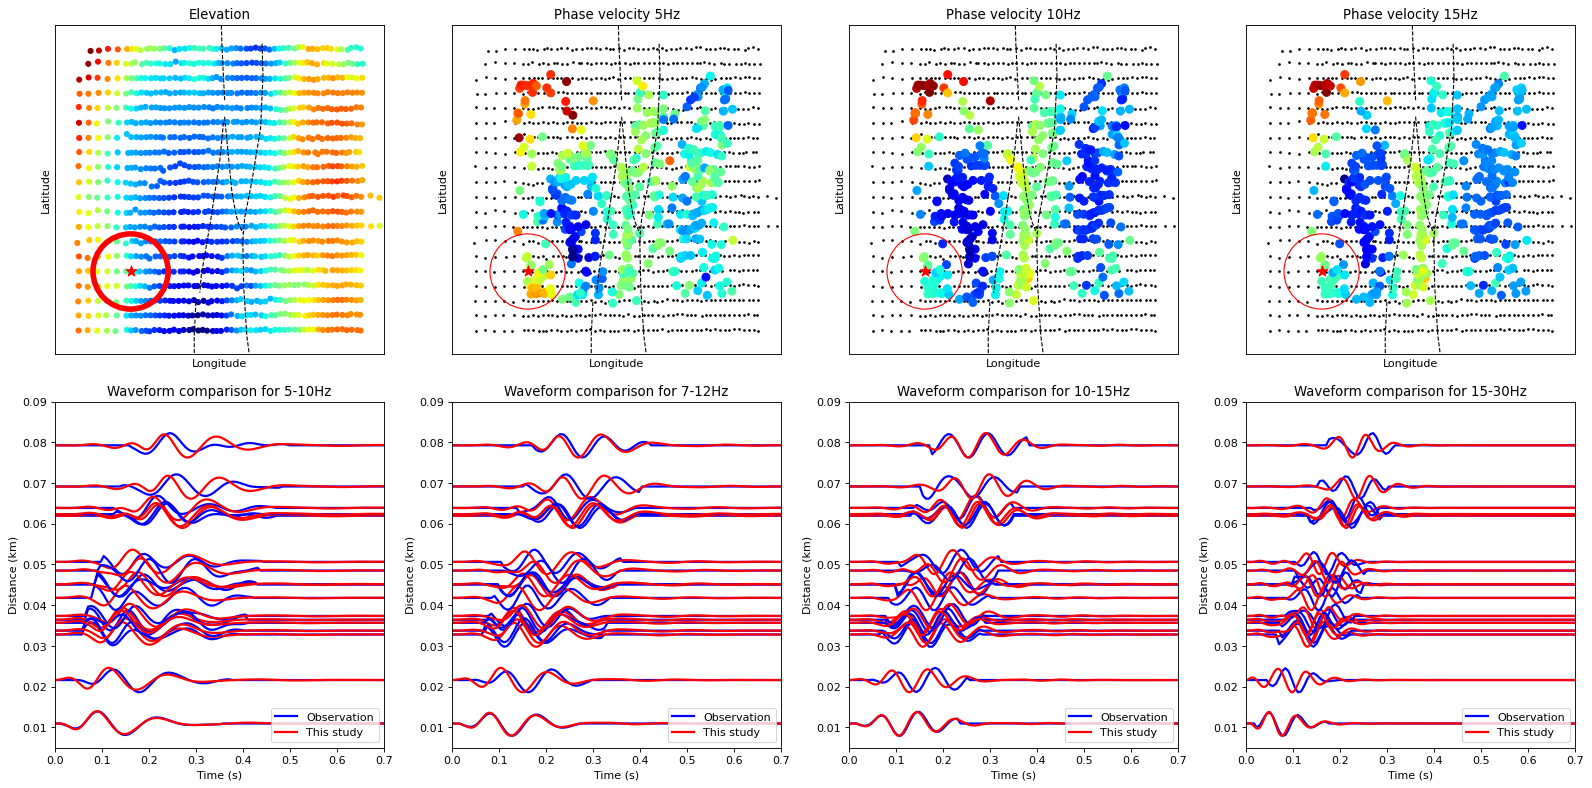

In [197]:
#for isrc in range(1,64):
for isrc in range(1,2):
    time0 = time.time()
    flag_inter = 1
    aver = np.array([0.45,0.5,0.5,0.5])
    t_left_shits = np.array([0.01,0,0,0])
    t_right_shits = np.array([0.33,0.25,0.21,0.15])
    plot_model(waveobsc_Ts[isrc],wavesync_Ts[isrc], r_plots[isrc], t, dir_image, bands,isrc,flag_inter,aver,t_left_shits,t_right_shits,faults)
    #plot_model(waveobsc_T,wavesync_T, r_plot, t, dir_image, bands,isrc,flag_inter,aver,t_left_shits,t_right_shits,faults)
    print('isrc: ', isrc, '  time: ', time.time()-time0)